# Programming Assignemnt - 18466874

### Imports

- <b>numpy</b> was used to handle a variety of mathematical operations.
- <b>pandas</b> is used to read in the `letter-recognition.data` file and store model results in dataframes.
- <b>sklearn's</b> `train_test_split` method was used to split the letter-recognition data into trianing and testing sections.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Multi_Layer_Perceptron Class

In [2]:
class Multi_Layer_Perceptron:
    def __init__(self, NI, NH, NO, activation_type):
        self.activation_type, self.e = activation_type, []
        self.NI, self.NH, self.NO = NI, NH, NO
        self.W1, self.W2 = np.array, np.array
        self.dW1, self.dW2 = np.array, np.array
        self.Z1, self.Z2 = np.array, np.array
        self.H, self.O = np.array, np.array
        
    def sigmoid_activation(self, inputs, derivative=False):
        return (np.exp(-inputs)/(1+np.exp(-inputs))**2) if derivative else (1 / (1+np.exp(-inputs)))
    
    # Source: https://en.wikipedia.org/wiki/Activation_function
    def tanh_activation(self, inputs, derivative=False):
        tanh = (2 / (1 + np.exp(inputs * -2))) - 1
        return (1-(np.power(tanh, 2))) if derivative else tanh
    
    # Source: https://en.wikipedia.org/wiki/Activation_function
    def softmax_activation(self, inputs, derivative=False):
        ex = np.exp(inputs - np.max(inputs, axis=-1, keepdims=True))
        ex2 = (ex/np.sum(ex, axis=-1,keepdims=True))
        return ex2 * (1-ex2) if derivative else ex2
    
    def randomise(self, small=False):
        if small:
            self.W2 = np.array((np.random.uniform(-0.1, 0.1, (self.NH, self.NO))).tolist())
            self.W1 = np.array((np.random.uniform(-0.1, 0.1, (self.NI, self.NH))).tolist())
        else:
            self.W2 = np.array((np.random.uniform(0, 1, (self.NH, self.NO))).tolist())
            self.W1 = np.array((np.random.uniform(0, 1, (self.NI, self.NH))).tolist())
        self.dW2 = np.zeros_like(self.W2)
        self.dW1 = np.zeros_like(self.W1)
        
    def forward(self, vectors):
        self.Z1 = np.dot(vectors, self.W1)
        if self.activation_type == 'sig':
            self.H = self.sigmoid_activation(self.Z1)
        elif self.activation_type == 'tanh': 
            self.H = self.tanh_activation(self.Z1)
        elif self.activation_type == 'softmax': 
            self.H = self.softmax_activation(self.Z1)
        else: 
            print("ERROR: INVALID ACTIVATION TYPE")
            
        self.Z2 = np.dot(self.H, self.W2)
        
        if self.activation_type == 'sig':
            self.O = self.sigmoid_activation(self.Z2) 
        elif self.activation_type == 'tanh':
            self.O = self.tanh_activation(self.Z2) 
        elif self.activation_type == 'softmax': 
            self.O = self.softmax_activation(self.Z2)   
        else:
            print("ERROR: INVALID ACTIVATION TYPE")

    def backwards(self, vectors, value):
        error = np.subtract(value, self.O)
        if self.activation_type == 'sig':
            a2, a1 = self.sigmoid_activation(self.Z2, True), self.sigmoid_activation(self.Z1, True)
        elif self.activation_type == 'tanh':
            a2, a1 = self.tanh_activation(self.Z2, True), self.tanh_activation(self.Z1, True)
        elif self.activation_type == 'softmax': 
            a2, a1 = self.softmax_activation(self.Z2, True), self.softmax_activation(self.Z1, True)
        else:
            print("ERROR: INVALID ACTIVATION TYPE")
        
        dW2a = error*a2
        self.dW2 = np.dot(self.H.T, dW2a)
        
        l1 = np.dot(dW2a, self.W2.T)
        dW1a = l1*a1
        self.dW1 = np.dot(vectors.T, dW1a)
        
        err = np.mean(np.abs(error))
        self.e.append(err)
        return err
    
    def update_weights(self, lr):
        self.W2 = np.add(self.W2, lr * self.dW2)
        self.W1 = np.add(self.W1, lr * self.dW1)
        self.dW2 = np.zeros_like(self.W2)  
        self.dW1 = np.zeros_like(self.W1)


# Task 1 -  XOR Problem

In [76]:
# This function handles the bulk of the logic for writing XOR MLP results to the logs and
# storing results for displaying in plots and tables
def generate_xor(EPOCHS, LR, NH, NI, NO, f, main_arr, mlp_arr, weights_range):
    X = np.array([ [0, 0], [1, 0], [0, 1], [1, 1] ])
    y = np.array([ [0], [1], [1], [0] ])
    xor_mlp =  Multi_Layer_Perceptron(NI, NH, NO, 'sig')
    if weights_range == 'small':
        xor_mlp.randomise(True)
    else:
        xor_mlp.randomise()
        
    print('Learning Rate:\t'+str(LR)+'\n'+'\n\n'+'Pre-Training:\n', file=f)
    for i in range(len(X)):
        xor_mlp.forward(X[i])
        print("Target:\t"+str(y[i])+" | Predicted:\t"+ str(xor_mlp.O), file=f)

    print('\n\n'+'Training:\n', file=f)
    inner_arr = [LR]
    for epoch in range(EPOCHS):
        xor_mlp.forward(X)
        err = xor_mlp.backwards(X, y)
        xor_mlp.update_weights(LR)
        if (epoch + 1) in [100, 1000, 10000, 100000, 1000000]:
            space = 7-len(str(epoch+i))
            spacing = space*" "
            print('Epoch:\t'+str(epoch+1)+ spacing +" | Error:\t"+str(err), file=f)
            inner_arr.append(round(err, 6))

    print('\n\n'+'Post Training:\n', file=f)
    accuracy = 0
    for i in range(len(X)):
        xor_mlp.forward(X[i])
        print("Target:\t"+str(y[i])+" | Predicted:\t"+ str(xor_mlp.O), file=f)
        accuracy += (1-xor_mlp.O[0]) if (y[i][0] == 0) else xor_mlp.O[0]

    print('\n\n'+'Accuracy:\t'+ str(accuracy/4), file=f)
    print('\n\n**************************************************************\n\n', file=f)
    inner_arr.append(round(accuracy/4, 6))
    main_arr.append(inner_arr)
    mlp_arr.append(xor_mlp)

In [77]:
# Declaring and assigning the XOR MLP constants
XOR_NI, XOR_NO, EPOCHS = 2, 1, 1000000
XOR_LEARNING_RATES = [0.05, 0.25, 0.5, 0.75, 1]

In [78]:
# This function creates the new file to store the XOR MLP results and invokes the 
# generate_xor function to generate the results
def generate_xor_with_hidden_units(NH, main_arr, mlp_arr, weights_range='large'):
    f = open('logs/xor/hidden_units_'+str(NH)+'_weight_range_' + weights_range + '.txt', 'w')
    print(''+'Constants:\n', file=f)
    print('Input Units:\t\t'+str(XOR_NI)+'\n'+'Output Units:\t\t'+str(XOR_NO)+'\n'+'Hidden Units:\t\t'+str(NH)+'\n'+'Weight Range:\t\t'+str(weights_range), file=f)
    print('\n**************************************************************\n', file=f)
    for i in range(len(XOR_LEARNING_RATES)):
        generate_xor(EPOCHS, XOR_LEARNING_RATES[i], NH, XOR_NI, XOR_NO, f, main_arr, mlp_arr, weights_range)
    f.close()
    return main_arr, mlp_arr

In [79]:
# This function generates a dataframe to store the XOR MLP results
def generate_dataframe(arr, hu):
    print("\033[1m" + "Hidden Units: " + str(hu) + "\033[0m")
    df = pd.DataFrame(arr)
    df = df.rename(columns={0: 'LR', 1: '100', 2: '1000', 3: '10000', 4:'100000', 5:'1000000', 6: 'Accuracy'})
#     df = df.rename(columns={0: 'LR', 1: '100', 2: '1000', 3: '10000', 4: 'Accuracy'})
    return df

In [80]:
# This function creates a plot showing errors of XOR MLPs with different learning rates across epochs 
# for a given number of hidden units
def visualise_xor(mlps, hu):
    for i, lr in enumerate(XOR_LEARNING_RATES):
        plt.plot(mlps[i].e[:10001], label=str(lr))
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend(loc="upper right", title="Learning Rate", fontsize='small', fancybox=True)
    plt.title(f"XOR: {str(hu)} Hidden Units")
    plt.show()

In [81]:
# This function creates a plot showing errors of XOR MLPs with different numbers of hidden units across epochs
# for a given learning rate
def visualize_xor_across_hidden_units(mlps, j):
    for i, mlp in enumerate(mlps):
        m = mlp[j]
        plt.plot(m.e[:1200], label=str(i+3))
    plt.xlabel("Epochs")
    plt.ylabel("Error")  
    plt.legend(loc="upper right", title="No. Hidden Units", fontsize='small', fancybox=True)
    plt.title(f"XOR: Learning rate {XOR_LEARNING_RATES[j]}")
    plt.show() 

#### Visualising error values of XOR MLPs with different learning rates across epochs for a given number of hidden units

Hidden Units: 3


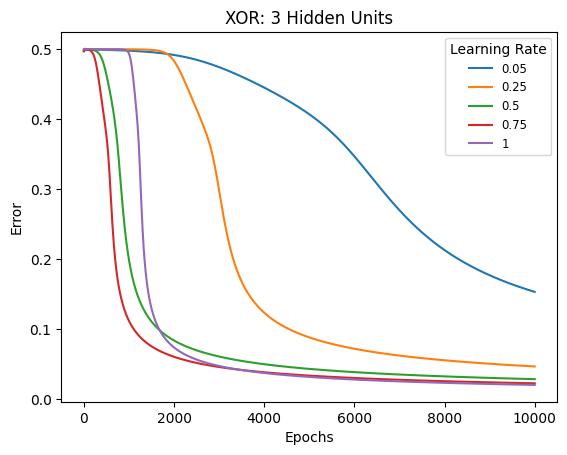

,LR,100,1000,10000,100000,1000000,Accuracy
0,0.05,0.499042,0.497759,0.153316,0.028434,0.008342,0.991658
1,0.25,0.500005,0.499771,0.046832,0.012047,0.003661,0.996339
2,0.50,0.499859,0.199851,0.028686,0.008349,0.002572,0.997428
3,0.75,0.499242,0.112190,0.022786,0.006772,0.002095,0.997905
4,1.00,0.500022,0.493844,0.020463,0.005867,0.001811,0.998189


In [9]:
xor_3_hu_errors, xor_3_hu_mlps = generate_xor_with_hidden_units(3, [], [])
xor_3hu_df = generate_dataframe(xor_3_hu_errors, 3)
visualise_xor(xor_3_hu_mlps, 3)
xor_3hu_df.head()

Hidden Units: 4


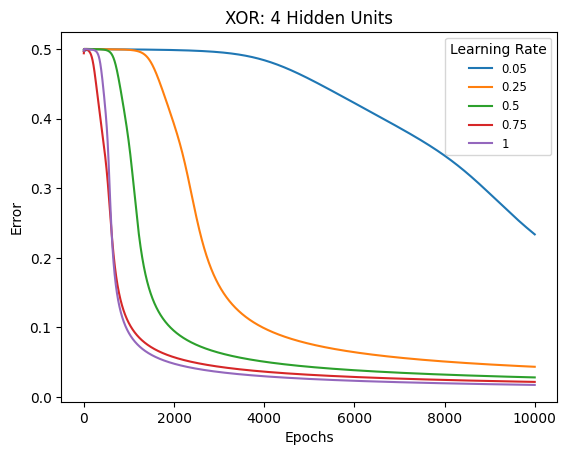

,LR,100,1000,10000,100000,1000000,Accuracy
0,0.05,0.499320,0.499468,0.233762,0.027460,0.008108,0.991892
1,0.25,0.500094,0.498893,0.043447,0.011650,0.003600,0.996400
2,0.50,0.500107,0.365296,0.028158,0.007253,0.001843,0.998157
3,0.75,0.497834,0.106154,0.021719,0.006569,0.002061,0.997939
4,1.00,0.499750,0.091983,0.017374,0.005110,0.001579,0.998421


In [10]:
xor_4_hu_errors, xor_4_hu_mlps = generate_xor_with_hidden_units(4, [], [])
xor_4hu_df = generate_dataframe(xor_4_hu_errors, 4)
visualise_xor(xor_4_hu_mlps, 4)
xor_4hu_df.head()

Hidden Units: 5


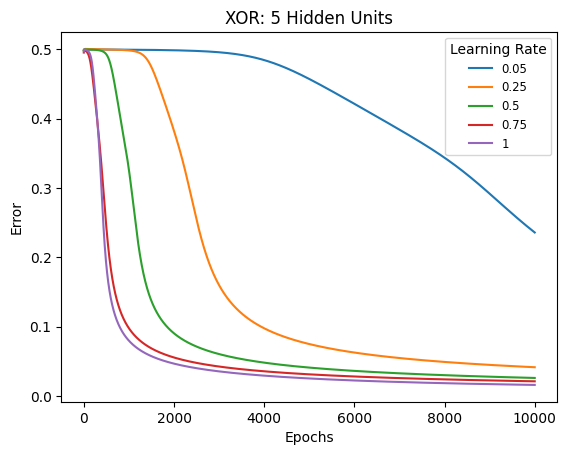

,LR,100,1000,10000,100000,1000000,Accuracy
0,0.05,0.499711,0.499564,0.235957,0.026493,0.006831,0.993169
1,0.25,0.500529,0.498534,0.041536,0.009124,0.002720,0.997280
2,0.50,0.499838,0.326774,0.026075,0.006201,0.001909,0.998091
3,0.75,0.492849,0.097865,0.021222,0.006372,0.001983,0.998017
4,1.00,0.497152,0.079889,0.016010,0.004560,0.001451,0.998549


In [11]:
xor_5_hu_errors, xor_5_hu_mlps = generate_xor_with_hidden_units(5, [], [])
xor_5hu_df = generate_dataframe(xor_5_hu_errors, 5)
visualise_xor(xor_5_hu_mlps, 5)
xor_5hu_df.head()

Hidden Units: 6


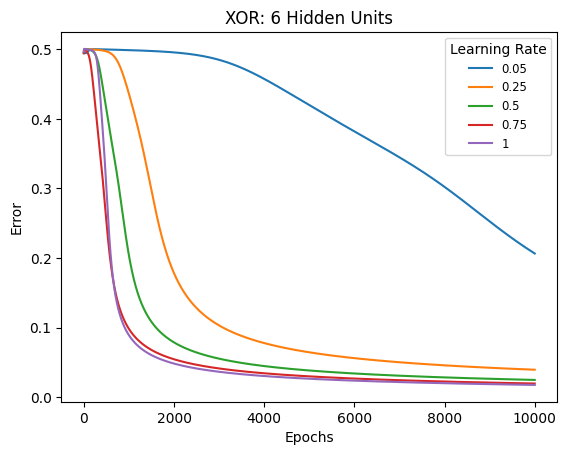

,LR,100,1000,10000,100000,1000000,Accuracy
0,0.05,0.497410,0.498730,0.206478,0.022404,0.005626,0.994374
1,0.25,0.500050,0.436253,0.039427,0.010086,0.002816,0.997184
2,0.50,0.499617,0.204110,0.024759,0.006407,0.001892,0.998108
3,0.75,0.493010,0.098236,0.019612,0.004939,0.001489,0.998511
4,1.00,0.499659,0.089155,0.017578,0.004621,0.001308,0.998692


In [12]:
xor_6_hu_errors, xor_6_hu_mlps = generate_xor_with_hidden_units(6, [], [])
xor_6hu_df = generate_dataframe(xor_6_hu_errors, 6)
visualise_xor(xor_6_hu_mlps, 6)
xor_6hu_df.head()

Hidden Units: 7


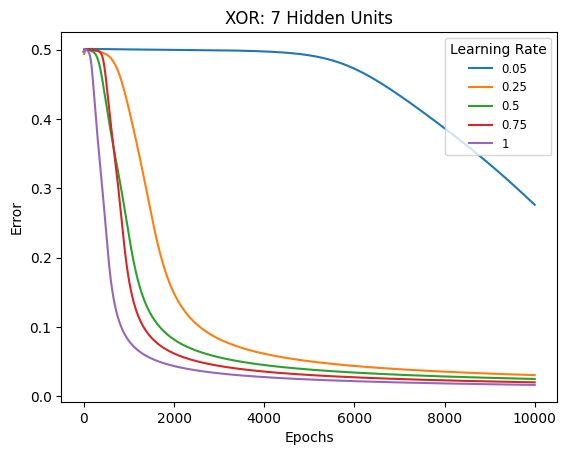

,LR,100,1000,10000,100000,1000000,Accuracy
0,0.05,0.500901,0.500329,0.276346,0.020306,0.005311,0.994689
1,0.25,0.499577,0.414448,0.030708,0.007867,0.002170,0.997830
2,0.50,0.499238,0.232437,0.025198,0.006926,0.001854,0.998146
3,0.75,0.500136,0.168436,0.020317,0.005639,0.001476,0.998524
4,1.00,0.497237,0.080165,0.016589,0.005014,0.001425,0.998575


In [13]:
xor_7_hu_errors, xor_7_hu_mlps = generate_xor_with_hidden_units(7, [], [])
xor_7hu_df = generate_dataframe(xor_7_hu_errors, 7)
visualise_xor(xor_7_hu_mlps, 7)
xor_7hu_df.head()

Hidden Units: 8


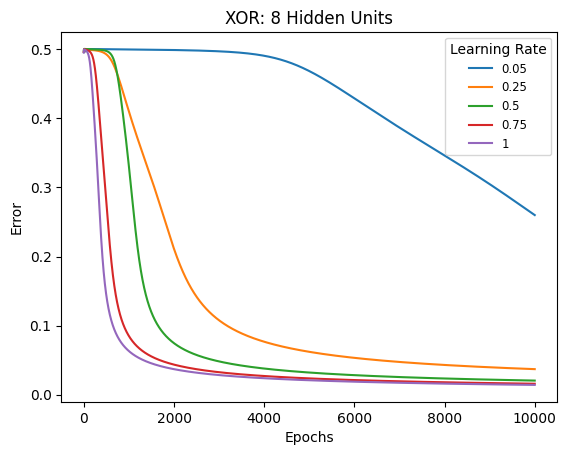

,LR,100,1000,10000,100000,1000000,Accuracy
0,0.05,0.500206,0.499870,0.260047,0.025683,0.006575,0.993425
1,0.25,0.499336,0.410171,0.036913,0.009643,0.002594,0.997406
2,0.50,0.500242,0.331036,0.020347,0.005538,0.001537,0.998463
3,0.75,0.498281,0.084946,0.015780,0.004716,0.001469,0.998531
4,1.00,0.492686,0.063093,0.014064,0.004047,0.001091,0.998909


In [14]:
xor_8_hu_errors, xor_8_hu_mlps = generate_xor_with_hidden_units(8, [], [])
xor_8hu_df = generate_dataframe(xor_8_hu_errors, 8)
visualise_xor(xor_8_hu_mlps, 8)
xor_8hu_df.head()

#### Visualising error values of XOR MLPs with different numbers of hidden units across epochs for a given learning rate

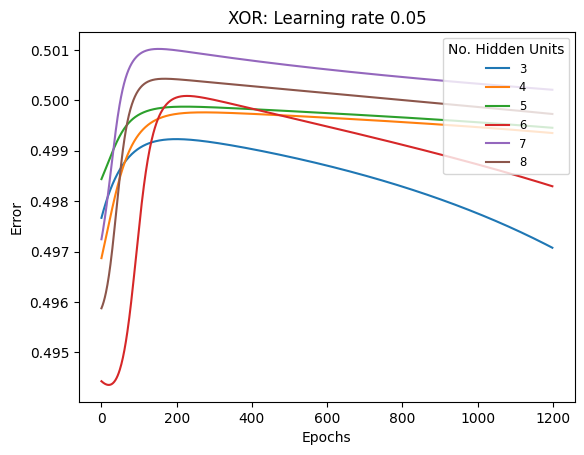

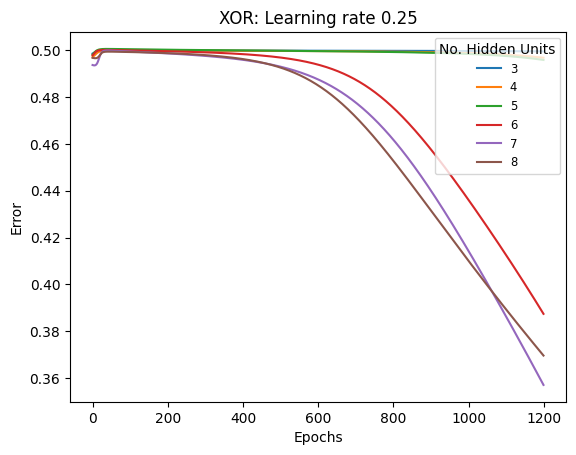

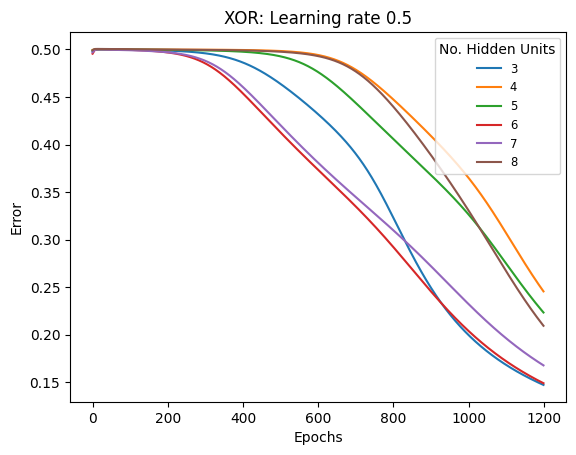

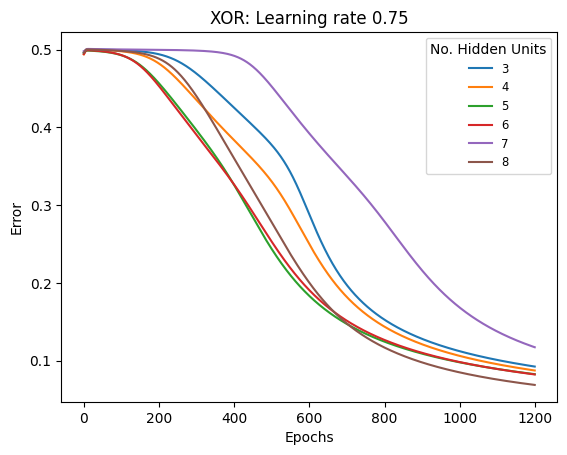

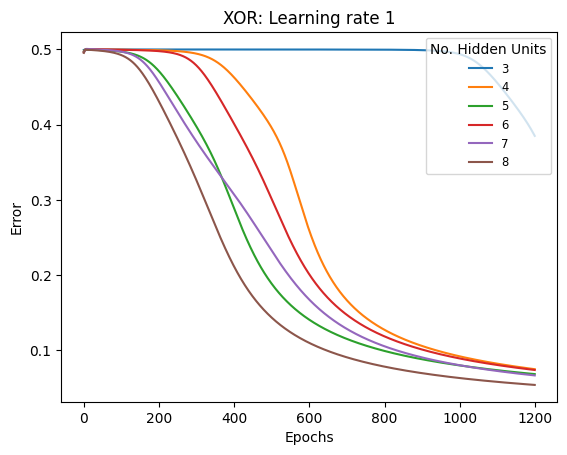

In [15]:
for i in range(5):
    visualize_xor_across_hidden_units([
        xor_3_hu_mlps,
        xor_4_hu_mlps,
        xor_5_hu_mlps,
        xor_6_hu_mlps,
        xor_7_hu_mlps,
        xor_8_hu_mlps
    ], i)

### Testing XOR MLPs with a lower weight range in the randomise function

Hidden Units: 3


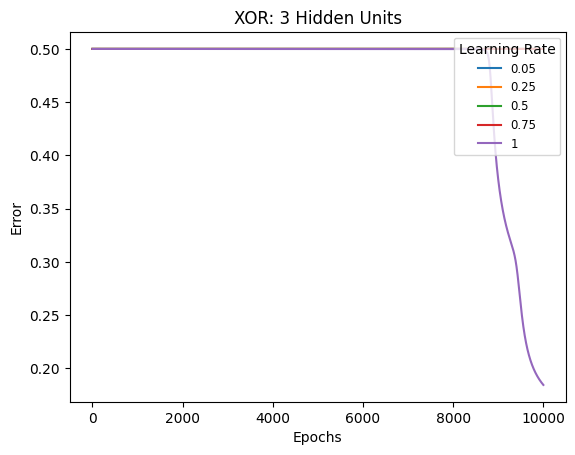

,LR,100,1000,10000,100000,1000000,Accuracy
0,0.05,0.5,0.5,0.500000,0.500000,0.010258,0.989742
1,0.25,0.5,0.5,0.500000,0.500000,0.008628,0.991372
2,0.50,0.5,0.5,0.500000,0.500000,0.006359,0.993641
3,0.75,0.5,0.5,0.499999,0.024506,0.004130,0.995870
4,1.00,0.5,0.5,0.184455,0.017924,0.003552,0.996448


In [82]:
xor_3_hu_errors_lr, xor_3_hu_mlps_lr = generate_xor_with_hidden_units(3, [], [], 'small')
xor_3hu_df_lr = generate_dataframe(xor_3_hu_errors_lr, 3)
visualise_xor(xor_3_hu_mlps_lr, 3)
xor_3hu_df_lr.head()

Hidden Units: 4


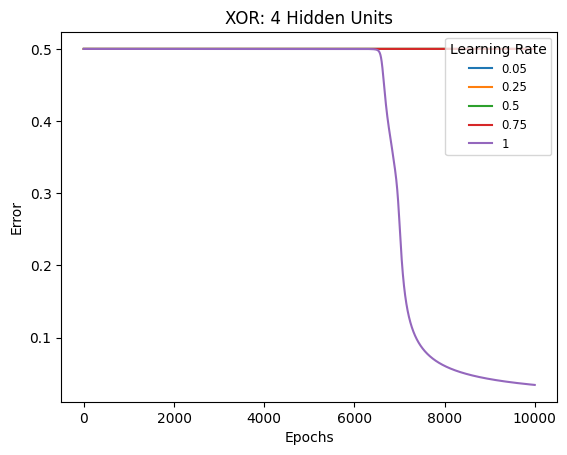

,LR,100,1000,10000,100000,1000000,Accuracy
0,0.05,0.5,0.500000,0.500000,0.500000,0.014884,0.985116
1,0.25,0.5,0.500000,0.500000,0.017489,0.003587,0.996413
2,0.50,0.5,0.500000,0.500000,0.008653,0.002352,0.997648
3,0.75,0.5,0.500000,0.500000,0.007437,0.002020,0.997980
4,1.00,0.5,0.499999,0.034303,0.005268,0.001604,0.998396


In [84]:
xor_4_hu_errors_lr, xor_4_hu_mlps_lr = generate_xor_with_hidden_units(4, [], [], 'small')
xor_4hu_df_lr = generate_dataframe(xor_4_hu_errors_lr, 4)
visualise_xor(xor_4_hu_mlps_lr, 4)
xor_4hu_df_lr.head()

# Task 2 - SIN Problem

In [91]:
# This function handles the bulk of the logic for writing SIN MLP results to the logs and
# storing results for displaying in plots and tables
def generate_sin(EPOCHS, LR, NH, NI, NO, f, main_arr, mlp_arr, weights_range):
    X, y = [], []
    
    print('Learning Rate:\t'+str(LR)+'\n'+'\n\n'+'Pre-Training:\n', file=f)
    for i in range(500):
        v = list(np.random.uniform(-1,1,4))
        v = [float(v[0]), float(v[1]), float(v[2]), float(v[3])]
        X.append(v)
    X = np.array(X)
    
    for i in range(500):
        y.append(np.sin([X[i][0] - X[i][1] + X[i][2] - X[i][3]]))
    
    sin_mlp = Multi_Layer_Perceptron(NI, NH, NO, 'tanh')
    if weights_range == 'small':
        sin_mlp.randomise(True)
    else:
        sin_mlp.randomise()

    for i in range(400):
        sin_mlp.forward(X[i])
        print("Target:\t"+str(y[i])+" \t\t|\t\t Predicted:\t"+ str(sin_mlp.O), file=f)

    print('\n\n'+'Training:\n', file=f)
    inner_arr = [LR]
    for epoch in range(EPOCHS):
        sin_mlp.forward(X[:400])
        err = sin_mlp.backwards(X[:400], y[:400])
        sin_mlp.update_weights(LR)
        
        if (epoch + 1) in [100, 1000, 10000, 100000, 1000000]:
            space = 7-len(str(epoch+i))
            spacing = space*" "
            print('Epoch:\t'+str(epoch+1)+ spacing +" | Error:\t"+str(err), file=f)
            inner_arr.append(round(err, 6))

    print('\n\n'+'Post Training:\n', file=f)
    margin = 0
    for i in range(400, len(X)):
        sin_mlp.forward(X[i])
        print("Target:\t"+str(y[i])+"\t\t\ | \t\tPredicted: "+ str(sin_mlp.O), file=f)
        margin = margin + np.abs(y[i][0] - sin_mlp.O[0])
            
    accuracy = (1-(margin/100))
    
    print('\n\n'+'Accuracy:\t'+ str(accuracy), file=f)
    print('\n\n**************************************************************\n\n', file=f)
    inner_arr.append(round(accuracy, 6))
    main_arr.append(inner_arr)
    mlp_arr.append(sin_mlp)

In [92]:
# Declaring and assigning the SIN MLP constants
SIN_NI, SIN_NO, SIN_EPOCHS = 4, 1, 100000
SIN_LEARNING_RATES = [0.1, 0.01, 0.001, 0.0001]

In [93]:
# This function creates the new file to store the SIN MLP results and invokes the generate_sin function to 
# generate the results
def generate_sin_with_hidden_units(NH, main_arr, mlp_arr, weights_range='large'):
    f = open('logs/sin/hidden_units_'+str(NH)+'_weight_range_' + weights_range +'.txt', 'w')
    print(''+'Constants:\n', file=f)
    print('Input Units:\t\t'+str(SIN_NI)+'\n'+'Output Units:\t\t'+str(SIN_NO)+'\n'+'Hidden Units:\t\t'+str(NH)+'\n'+'Weight Range:\t\t'+str(weights_range), file=f)
    print('\n**************************************************************\n', file=f)
    for i in range(len(SIN_LEARNING_RATES)):
        generate_sin(SIN_EPOCHS, SIN_LEARNING_RATES[i], NH, SIN_NI, SIN_NO, f, main_arr, mlp_arr, weights_range)
    f.close()
    return main_arr, mlp_arr

In [94]:
# This function generates a dataframe to store the SIN MLP results
def generate_dataframe(arr, hu):
    print("\033[1m" + "Hidden Units: " + str(hu) + "\033[0m")
    df = pd.DataFrame(arr)
    df = df.rename(columns={0: 'LR', 1: '100', 2: '1000', 3: '10000', 4: '100000', 5: 'Accuracy'})
    return df

In [95]:
# This function creates a plot showing errors of SIN MLPs with different learning rates across epochs 
# for a given number of hidden units
def visualise_sin(mlps, hu):
    for i, lr in enumerate(SIN_LEARNING_RATES):
        plt.plot(mlps[i].e[10:2001], label=str(lr))
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend(loc="upper right", title="Learning Rate", fontsize='small', fancybox=True)
    plt.title(f"SIN: {str(hu)} Hidden Units")
    plt.show()

In [96]:
# This function creates a plot showing errors of SIN MLPs with different numbers of hidden units across epochs
# for a given learning rate
def visualize_sin_across_hidden_units(mlps, j):
    for i, mlp in enumerate(mlps):
        m = mlp[i]
        plt.plot(m.e[10:1200], label=str((i*10)+10))
    plt.xlabel("Epochs")
    plt.ylabel("Error")  
    plt.legend(loc="upper right", title="No. Hidden Units", fontsize='small', fancybox=True)
    plt.title(f"SIN: Learning rate {SIN_LEARNING_RATES[j]}")
    plt.show() 

#### Visualising error values of SIN MLPs with different learning rates across epochs for a given number of hidden units

Hidden Units: 5


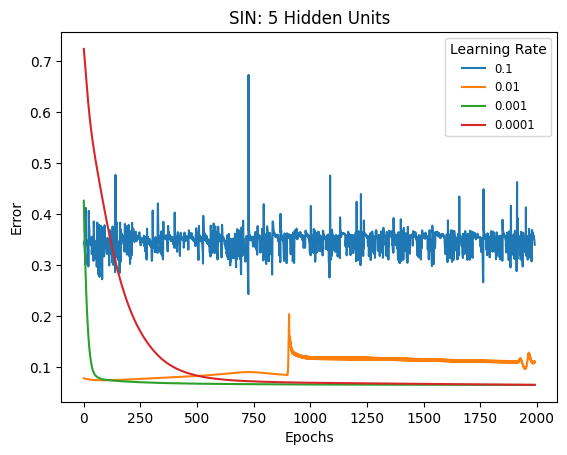

,LR,100,1000,10000,100000,Accuracy
0,0.1000,0.316905,0.357582,0.365631,0.371648,0.551748
1,0.0100,0.074604,0.117032,0.106691,0.107711,0.903669
2,0.0010,0.076020,0.066267,0.065489,0.058921,0.936284
3,0.0001,0.413584,0.069713,0.057837,0.051700,0.926646


In [29]:
sin_5_hu_errors, sin_5_hu_mlps = generate_sin_with_hidden_units(5, [], [])
sin_5hu_df = generate_dataframe(sin_5_hu_errors, 5)
visualise_sin(sin_5_hu_mlps, 5)
sin_5hu_df.head()

Hidden Units: 10


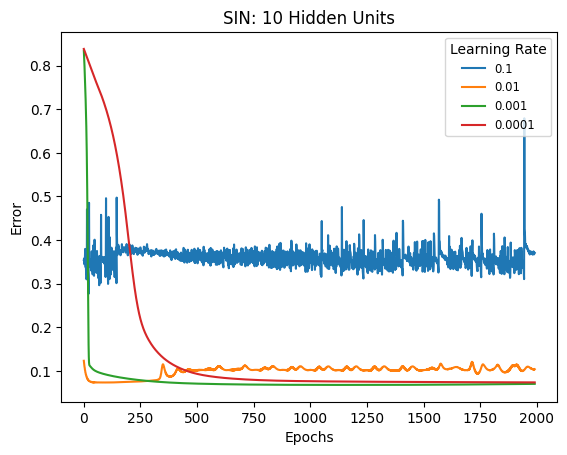

,LR,100,1000,10000,100000,Accuracy
0,0.1000,0.361265,0.378742,0.378215,0.324742,0.585059
1,0.0100,0.073692,0.101844,0.110306,0.107698,0.892301
2,0.0010,0.092989,0.068147,0.068713,0.049240,0.935073
3,0.0001,0.714829,0.076579,0.070297,0.065904,0.933153


In [34]:
sin_10_hu_errors, sin_10_hu_mlps = generate_sin_with_hidden_units(10, [], [])
sin_10hu_df = generate_dataframe(sin_10_hu_errors, 10)
visualise_sin(sin_10_hu_mlps, 10)
sin_10hu_df.head()

Hidden Units: 20


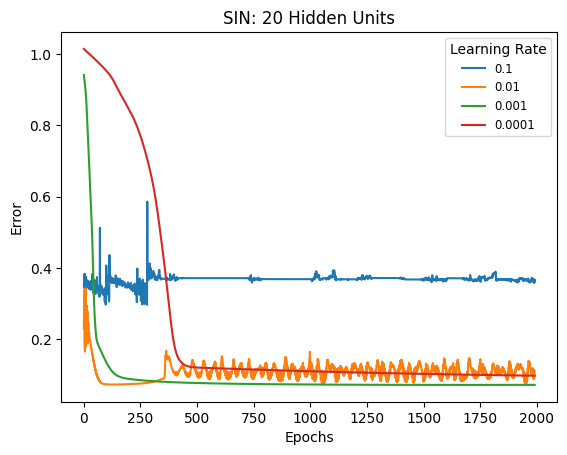

,LR,100,1000,10000,100000,Accuracy
0,0.1000,0.326049,0.369105,0.360705,0.363216,0.610778
1,0.0100,0.074844,0.110056,0.104326,0.097103,0.909899
2,0.0010,0.148958,0.073527,0.057961,0.043992,0.951650
3,0.0001,0.960616,0.110810,0.078044,0.062830,0.937751


In [31]:
sin_20_hu_errors, sin_20_hu_mlps = generate_sin_with_hidden_units(20, [], [])
sin_20hu_df = generate_dataframe(sin_20_hu_errors, 20)
visualise_sin(sin_20_hu_mlps, 20)
sin_20hu_df.head()

Hidden Units: 30


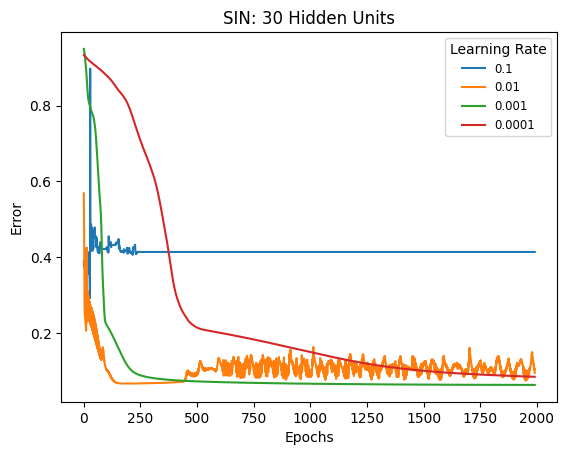

,LR,100,1000,10000,100000,Accuracy
0,0.1000,0.421762,0.413940,0.423122,0.412548,0.583826
1,0.0100,0.139396,0.097418,0.091477,0.112263,0.882348
2,0.0010,0.269518,0.066549,0.058479,0.046172,0.951314
3,0.0001,0.885927,0.151445,0.058730,0.057747,0.960856


In [32]:
sin_30_hu_errors, sin_30_hu_mlps = generate_sin_with_hidden_units(30, [], [])
sin_30hu_df = generate_dataframe(sin_30_hu_errors, 30)
visualise_sin(sin_30_hu_mlps, 30)
sin_30hu_df.head()

/var/folders/_c/_52q8fdj0298y8tzfrn3530c0000gn/T/ipykernel_26852/188455348.py:15: RuntimeWarning: overflow encountered in exp
  tanh = (2 / (1 + np.exp(inputs * -2))) - 1


Hidden Units: 40


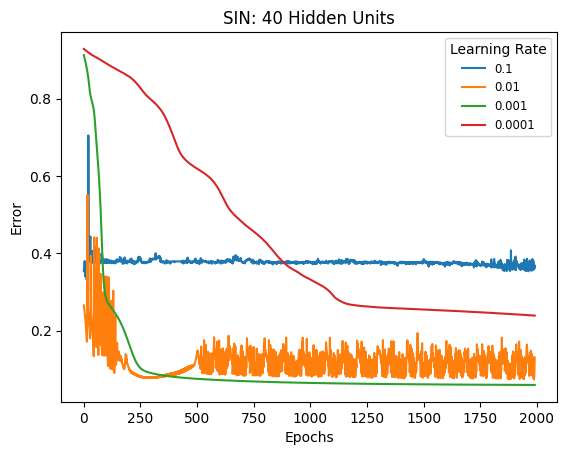

,LR,100,1000,10000,100000,Accuracy
0,0.1000,0.382099,0.376969,0.405807,0.398501,0.551004
1,0.0100,0.135501,0.083167,0.099795,0.107516,0.924792
2,0.0010,0.318095,0.065057,0.058568,0.039773,0.947707
3,0.0001,0.894868,0.335758,0.060636,0.060391,0.950894


In [35]:
sin_40_hu_errors, sin_40_hu_mlps = generate_sin_with_hidden_units(40, [], [])
sin_40hu_df = generate_dataframe(sin_40_hu_errors, 40)
visualise_sin(sin_40_hu_mlps, 40)
sin_40hu_df.head()

### Testing SIN MLPs with a lower weight range in the randomise function

Hidden Units: 5


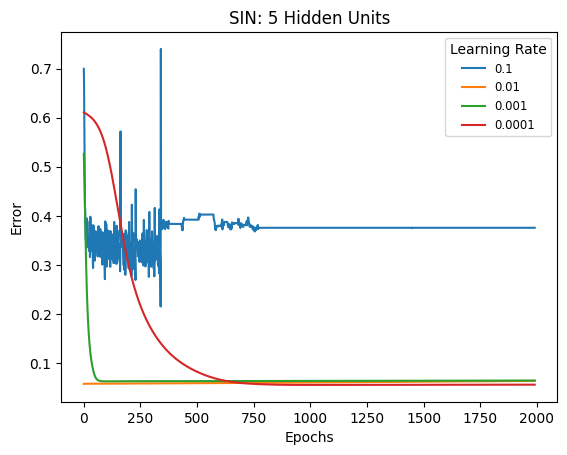

,LR,100,1000,10000,100000,Accuracy
0,0.1000,0.337688,0.375761,0.375761,0.371606,0.626935
1,0.0100,0.058247,0.060646,0.102548,0.101356,0.889763
2,0.0010,0.063005,0.063796,0.075823,0.064003,0.929672
3,0.0001,0.551669,0.055692,0.056274,0.057479,0.929951


In [97]:
sin_5_hu_errors_lr, sin_5_hu_mlps_lr = generate_sin_with_hidden_units(5, [], [], 'small')
sin_5hu_df_lr = generate_dataframe(sin_5_hu_errors_lr, 5)
visualise_sin(sin_5_hu_mlps_lr, 5)
sin_5hu_df_lr.head()

Hidden Units: 10


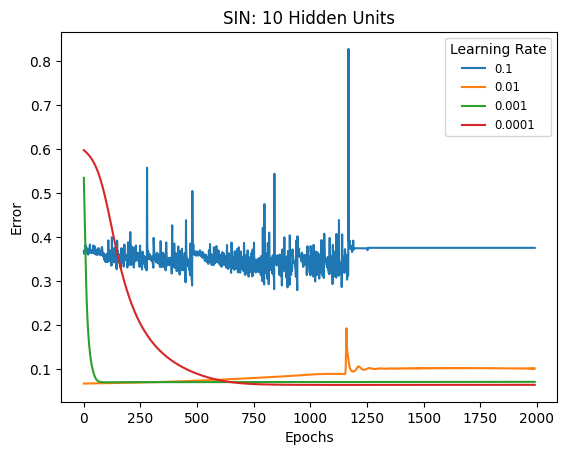

,LR,100,1000,10000,100000,Accuracy
0,0.1000,0.353874,0.348605,0.383477,0.373286,0.605023
1,0.0100,0.067310,0.086683,0.106222,0.108973,0.887498
2,0.0010,0.069456,0.070049,0.096591,0.052175,0.940262
3,0.0001,0.501388,0.063559,0.063919,0.071317,0.948480


In [99]:
sin_10_hu_errors_lr, sin_10_hu_mlps_lr = generate_sin_with_hidden_units(10, [], [], 'small')
sin_10hu_df_lr = generate_dataframe(sin_10_hu_errors_lr, 10)
visualise_sin(sin_10_hu_mlps_lr, 10)
sin_10hu_df_lr.head()

# Task 3 - Letter Recognition

In [3]:
# This function handles the bulk of the logic for writing Letter Recognition MLP results to the logs and
# storing results for displaying in plots and tables
def generate_letter(NI, NH, NO, X, y, testing_data, testing_outputs, EPOCHS, LR, letter_to_predict_test, f, main_arr, mlp_arr, weights_range):
    letter_mlp = Multi_Layer_Perceptron(NI, NH, NO, 'tanh')
    if weights_range == 'small':
        letter_mlp.randomise(True)
    else:
        letter_mlp.randomise()
        
    print('Learning Rate:\t'+str(LR)+'\n'+'\n\n'+'\nTraining:\n', file=f)
    
    inner_arr = [LR]
    for i in range(1, EPOCHS+1):
        error = 0
        letter_mlp.forward(np.array(X))
        error += letter_mlp.backwards(np.array(X), np.array(y))
        letter_mlp.update_weights(LR)
        if i % 10000 == 0:
            inner_arr.append(round(error, 6))
        if i % 1000 == 0:
            print("Epochs: " + str(error) + "\t|\t" + "Error: " + str(i) + "\n", file=f)

    print("\n\nTesting output\n", file=f)
    predictions, correct = [], 0
    for i in range(len(testing_data)):
        letter_mlp.forward(testing_data[i])
        character_prediction = update_to_character(letter_mlp.O)
        predictions.append([letter_mlp.O[0]])
        if i % 10 == 0:
            print("Target: " + letter_to_predict_test.values[i] + " \t|\t Prediction: " + str(character_prediction) + "\n", file=f)
        if str(character_prediction) == letter_to_predict_test.values[i]:
            correct += 1
    accuracy = (correct/len(predictions))

    print('\n\n'+'Accuracy:\t'+ str(accuracy) + "\n\n", file=f) 
    print('\n\n**************************************************************\n\n', file=f)
    inner_arr.append(round(accuracy, 6))
    main_arr.append(inner_arr)
    mlp_arr.append(letter_mlp)          

In [4]:
# Declaring and assigning the letter recognition constants
LETTER_NI, LETTER_NO, LETTER_EPOCHS = 16, 26, 100000
LETTER_LEARNING_RATES = [0.000005]

# Defining the columns of the dataset and then assigning them to the dataframe
cols = ["letter", "x-box", "y-box", "width", "height", 
        "onpix", "x-bar", "y-bar", "x2bar", "y2bar", 
        "xybar", "x2ybr", "xy2br", "x-ege", "xegvy", "y-ege", "yegvx"]
df = pd.read_csv("data/letter-recognition.data", names=cols)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=8)

# Getting the letters to predict
letter_to_predict_train = train_data.pop('letter')
letter_to_predict_test = test_data.pop('letter')
letter_to_predict_train_list, letter_to_predict_test_list = [], []

# Auxiliary functions
def update_to_list(dataframe):
    output = []
    for target in dataframe:
        output_arr = [0]*26
        output_arr[ord(str(target))-ord('A')] = 1
        output.append(output_arr)
    return output

def update_to_character_2(num):
    return chr(int(num) + ord('A'))

def update_to_character(arr):
    li = list(arr)
    idx = li.index(max(li))
    return chr(idx + ord('A'))

# Updating the trainnig and test data format
letter_to_predict_train_list, letter_to_predict_test_list = update_to_list(letter_to_predict_train), update_to_list(letter_to_predict_test)
train_data = np.array(train_data)
test_data = np.array(test_data)

In [5]:
# This function creates the new file to store the Letter Recognition MLP results and invokes the 
# generate_letter function to generate the results
def generate_letters_with_hidden_units(LETTER_NH, main_arr, mlp_arr, weights_range='large'):
    f = open('logs/letter_recognition/hidden_units_'+str(LETTER_NH)+'_weight_range_' + weights_range + '.txt', 'w')
    print(''+'Constants:\n', file=f)
    print('Input Units:\t\t'+str(LETTER_NI)+'\n'+'Output Units:\t\t'+str(LETTER_NO)+'\n'+'Hidden Units:\t\t'+str(LETTER_NH)+'\n'+'Weight Range:\t\t'+str(weights_range), file=f)
    print('\n**************************************************************\n', file=f)
    for i in range(len(LETTER_LEARNING_RATES)):
        generate_letter(LETTER_NI, 
                        LETTER_NH, 
                        LETTER_NO, 
                        train_data, 
                        letter_to_predict_train_list, 
                        test_data, 
                        letter_to_predict_test_list, 
                        LETTER_EPOCHS,
                        LETTER_LEARNING_RATES[i], 
                        letter_to_predict_test,
                        f,
                        main_arr,
                        mlp_arr,
                        weights_range
                       )
    f.close()
    return main_arr, mlp_arr

In [6]:
# This function generates a dataframe to store the Letter Recognition MLP results
def generate_dataframe(arr, hu):
    print("\033[1m" + "Hidden Units: " + str(hu) + "\033[0m")
    df = pd.DataFrame(arr)
#     df = df.rename(columns={0: 'LR', 1: '1000', 2: 'Accuracy'})
#     df = df.rename(columns={0: 'LR', 1: '20000', 2: '40000', 3: '60000', 4: '80000', 5: '100000', 6: 'Accuracy'})
#     df = df.rename(columns={0: 'LR', 1: '1000', 2: '2000', 3: '3000', 4: '4000', 5: '5000', 6: '6000', 7: '7000', 8: '8000', 9: '9000', 10: '10000', 11: 'Accuracy'})
    df = df.rename(columns={0: 'LR', 1: '10000', 2: '20000', 3: '30000', 4: '40000', 5: '50000', 6: '60000', 7: '70000', 8: '80000', 9: '90000', 10: '100000', 11: 'Accuracy'})

    return df


In [7]:
# This function creates a plot showing errors of SIN MLPs with different learning rates across epochs 
# for a given number of hidden units
def visualise_letter(mlps, hu):
    for i, lr in enumerate(LETTER_LEARNING_RATES):
        plt.plot(mlps[i].e[:2001], label=str(lr))
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend(loc="upper right", title="Learning Rate", fontsize='small', fancybox=True)
    plt.title(f"Letter Recognition: {str(hu)} Hidden Units")
    plt.show()

#### Visualising error values of Letter Recognition MLPs with different learning rates across epochs for a given number of hidden units

Hidden Units: 10


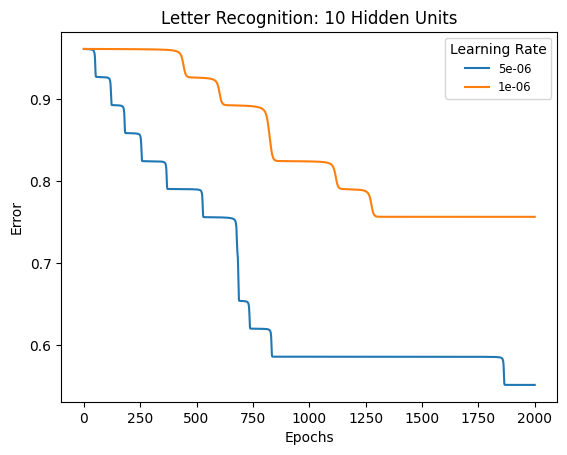

,LR,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,Accuracy
0,0.000005,0.586093,0.551722,0.517608,0.483685,0.415158,0.346514,0.312639,0.312638,0.312636,0.312633,0.0405
1,0.000001,0.823983,0.756463,0.756357,0.721772,0.654263,0.654237,0.654175,0.648601,0.551733,0.551716,0.0405


In [116]:
letter_10_hu_errors_lg, letter_10_hu_mlps_lg = generate_letters_with_hidden_units(10, [], [])
letter_10hu_df_lg = generate_dataframe(letter_10_hu_errors_lg, 10)
visualise_letter(letter_10_hu_mlps_lg, 10)
letter_10hu_df_lg.head()

### Testing Letter Recognition MLPs with a lower weight range in the randomise function

Hidden Units: 10


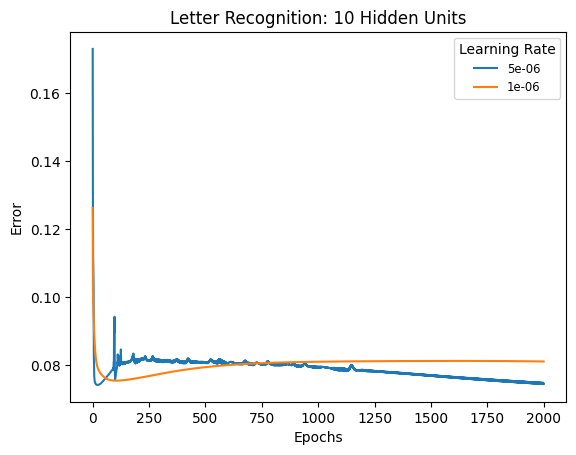

,LR,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,Accuracy
0,0.000005,0.079474,0.074732,0.070897,0.068666,0.066933,0.065423,0.064501,0.063938,0.063548,0.063242,0.3315
1,0.000001,0.080942,0.081019,0.079650,0.078685,0.077999,0.077458,0.077027,0.076675,0.076383,0.076134,0.4250


In [117]:
letter_10_hu_errors, letter_10_hu_mlps = generate_letters_with_hidden_units(10, [], [], 'small')
letter_10hu_df = generate_dataframe(letter_10_hu_errors, 10)
visualise_letter(letter_10_hu_mlps, 10)
letter_10hu_df.head()

Hidden Units: 20


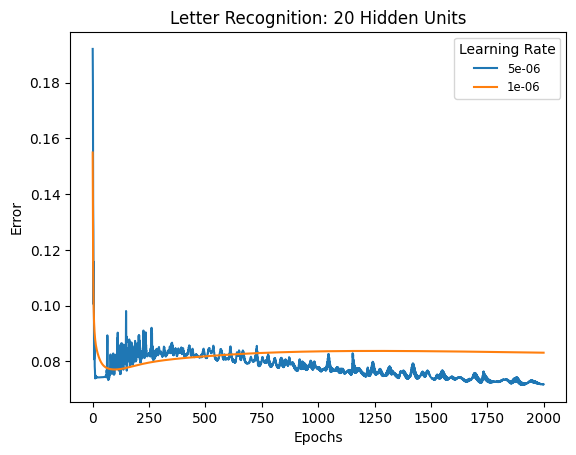

,LR,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,Accuracy
0,0.000005,0.077205,0.071666,0.069231,0.065204,0.063892,0.062811,0.062166,0.061317,0.060668,0.060012,0.61575
1,0.000001,0.083589,0.083114,0.082110,0.081322,0.080152,0.078740,0.077467,0.076411,0.075532,0.074732,0.64750


In [118]:
letter_20_hu_errors, letter_20_hu_mlps = generate_letters_with_hidden_units(20, [], [], 'small')
letter_20hu_df = generate_dataframe(letter_20_hu_errors, 20)
visualise_letter(letter_20_hu_mlps, 20)
letter_20hu_df.head()

Hidden Units: 30


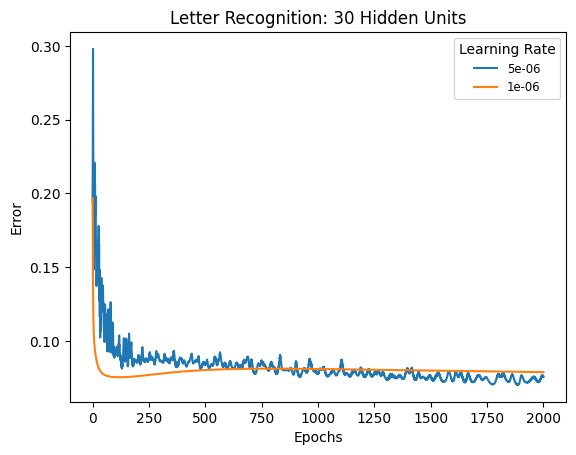

,LR,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,Accuracy
0,0.000005,0.078432,0.076327,0.069128,0.068353,0.065819,0.06333,0.063844,0.060799,0.062004,0.061026,0.71625
1,0.000001,0.080865,0.078759,0.076823,0.075083,0.073635,0.07238,0.071243,0.070202,0.069275,0.068463,0.65450


In [119]:
letter_30_hu_errors, letter_30_hu_mlps = generate_letters_with_hidden_units(30, [], [], 'small')
letter_30hu_df = generate_dataframe(letter_30_hu_errors, 30)
visualise_letter(letter_30_hu_mlps, 30)
letter_30hu_df.head()

Hidden Units: 40


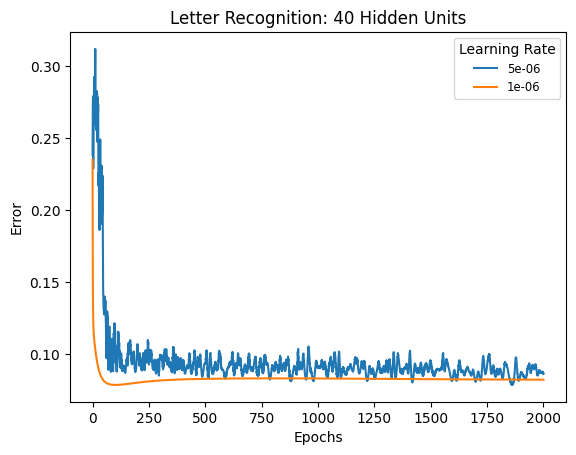

,LR,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,Accuracy
0,0.000005,0.090162,0.085915,0.079579,0.087608,0.077247,0.079569,0.076310,0.076136,0.073692,0.073635,0.758
1,0.000001,0.082974,0.082105,0.080963,0.079891,0.079120,0.078416,0.077694,0.076847,0.075941,0.075087,0.716


In [120]:
letter_40_hu_errors, letter_40_hu_mlps = generate_letters_with_hidden_units(40, [], [], 'small')
letter_40hu_df = generate_dataframe(letter_40_hu_errors, 40)
visualise_letter(letter_40_hu_mlps, 40)
letter_40hu_df.head()

### Testing Letter Recognition MLPs higher hidden units and higher epoch range

Hidden Units: 80


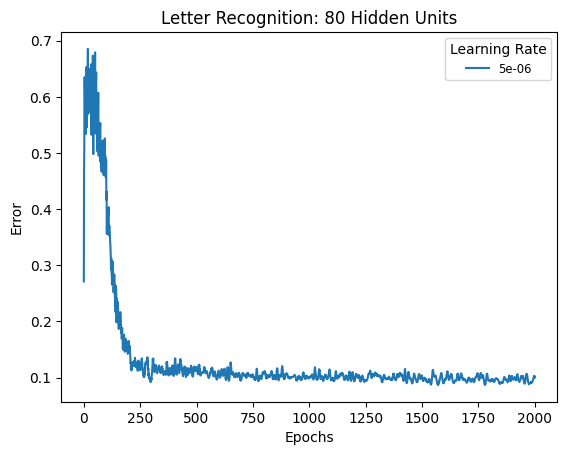

,LR,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,Accuracy
0,0.000005,0.086921,0.076431,0.074166,0.07439,0.069675,0.06799,0.069637,0.071464,0.067516,0.066743,0.842


In [132]:
letter_80_hu_errors, letter_80_hu_mlps = generate_letters_with_hidden_units(80, [], [], 'small')
letter_80hu_df = generate_dataframe(letter_80_hu_errors, 80)
visualise_letter(letter_80_hu_mlps, 80)
letter_80hu_df.head()

Hidden Units: 120


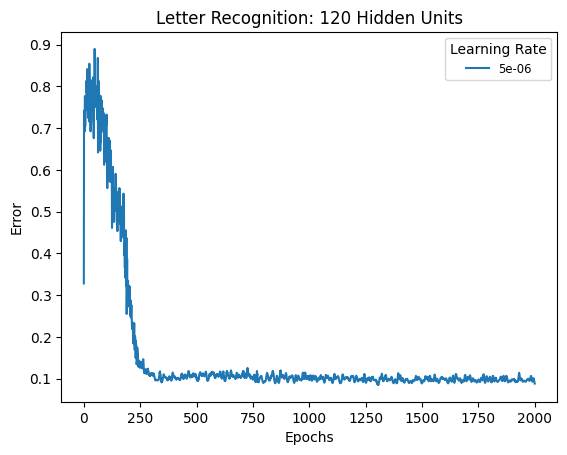

,LR,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,Accuracy
0,0.000005,0.082516,0.073181,0.070487,0.071675,0.071553,0.070681,0.068361,0.068976,0.068511,0.069878,0.88325


In [9]:
letter_120_hu_errors, letter_120_hu_mlps = generate_letters_with_hidden_units(120, [], [], 'small')
letter_120hu_df = generate_dataframe(letter_120_hu_errors, 120)
visualise_letter(letter_120_hu_mlps, 120)
letter_120hu_df.head()